In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from skimage.metrics import structural_similarity as ssim

# Training Example Networks

In [ ]:
#Caltech Birds Resolution 32x32
!python3 train_model.py --n_epochs 30000 --output_dir ./fine_tune/cub200_xent --dataset_name cub200_32 --lr 1e-5 --pretrained --train_set_size 200 --momentum 0.0 --xent
#CIFAR-100
!python3 train_model.py --n_epochs 30000 --output_dir ./fine_tune/cifar100_xent --dataset_name cifar100_all_classes --lr 1e-5 --pretrained --train_set_size 200 --momentum 0.0 --xent
#CIFAR-10
!python3 train_model.py --n_epochs 30000 --output_dir ./fine_tune/cifar10_xent --dataset_name cifar10_all_classes --lr 1e-5 --pretrained --train_set_size 50 --momentum 0.0 --xent

# Making Example Reconstructions

In [ ]:
#Caltech Birds Resolution 32x32
python3 make_reconstruction.py --output_dir fine_tune/cub200_xent --dataset_name cub200_32 --seed 0 --train_set_size 200 --max_iters 10000 --pretrained --both_kernels
#CIFAR-100
python3 make_reconstruction.py --output_dir fie_tune/cifar100_xent --dataset_name cifar100_all_classes --seed 0 --train_set_size 200 --max_iters 10000 --pretrained --both_kernels
#CIFAR-10
python3 make_reconstruction.py --output_dir fine_tune/cifar10_xent --dataset_name cifar10_all_classes --seed 0 --train_set_size 50 --max_iters 10000 --pretrained --both_kernels

# Visualizing the best reconstructions

In [53]:
#Helper function for finding the best set of reconstructions
def get_best_pairs(train_images, recons):
    train_images_flattened = train_images.reshape(train_images.shape[0], -1)
    recon_flattened = recons.reshape(recons.shape[0], -1)
    dists = np.sqrt(np.sum((train_images_flattened[:, None] - recon_flattened[None])**2, -1))
    dists = np.array(dists)

    best_pairs = []

    pair_dists = []


    while(len(best_pairs) < train_images.shape[0] and np.min(dists) < np.inf):
        loc = np.unravel_index(dists.argmin(), dists.shape)
        best_pairs.append([loc[0], loc[1]])

        pair_dists.append(dists[loc])

        dists[loc[0]] = np.inf
        dists[:, loc[1]] = np.inf
        
        
    return np.array(best_pairs)

def get_best_pairs_ssim(train_images, recons):
    train_images_flattened = train_images.reshape(train_images.shape[0], -1)
    recon_flattened = recons.reshape(recons.shape[0], -1)
    # dists = np.sqrt(np.sum((train_images_flattened[:, None] - recon_flattened[None])**2, -1))
    dists = np.zeros([train_images.shape[0], recon_flattened.shape[0]])
    
    for i in range(dists.shape[0]):
        for j in range(dists.shape[1]):
            dists[i,j] = 1 - ssim(train_images[i], recons[j], data_range=train_images[i].max() - train_images[i].min(), channel_axis = 2)

    best_pairs = []

    pair_dists = []


    while(len(best_pairs) < train_images.shape[0] and np.min(dists) < np.inf):
        loc = np.unravel_index(dists.argmin(), dists.shape)
        best_pairs.append([loc[0], loc[1]])

        pair_dists.append(dists[loc])

        dists[loc[0]] = np.inf
        dists[:, loc[1]] = np.inf
        
        
    return np.array(best_pairs)



#Helper function for plotting the images
def plot_images(images, clip = True, n_cols = 4, fig_ax = None, rescale = False):
    n_rows = int(max(int(np.ceil(images.shape[0]/n_cols)), 2))
    if fig_ax is None:
        fig, ax = plt.subplots(n_rows, 10, dpi = 200, figsize = (10, n_rows))
    else:
        fig, ax = fig_ax
    for i in range(images.shape[0]):
        r = i//n_cols
        c = i % n_cols
        # recons[i]
        rescaled = images[i] 
        
        if rescaled.shape[0] == 1:
            rescaled = images[:, :, 0]
        
        if clip:
            rescaled = np.clip(rescaled, 0, 1)
        if rescale:
            rescaled = rescaled - np.min(rescaled)
            rescaled = rescaled/np.max(rescaled)
        # print(np.min(recons[i]))
        ax[r][c].imshow(rescaled)
        ax[r][c].axis('off')
        
    return fig, ax

#Helper function for subtracting the mean
def correct_mean(images, mean):
    if images.shape[-1] == 1:
        return images + mean
    else:
        return images + mean[None, None, None]

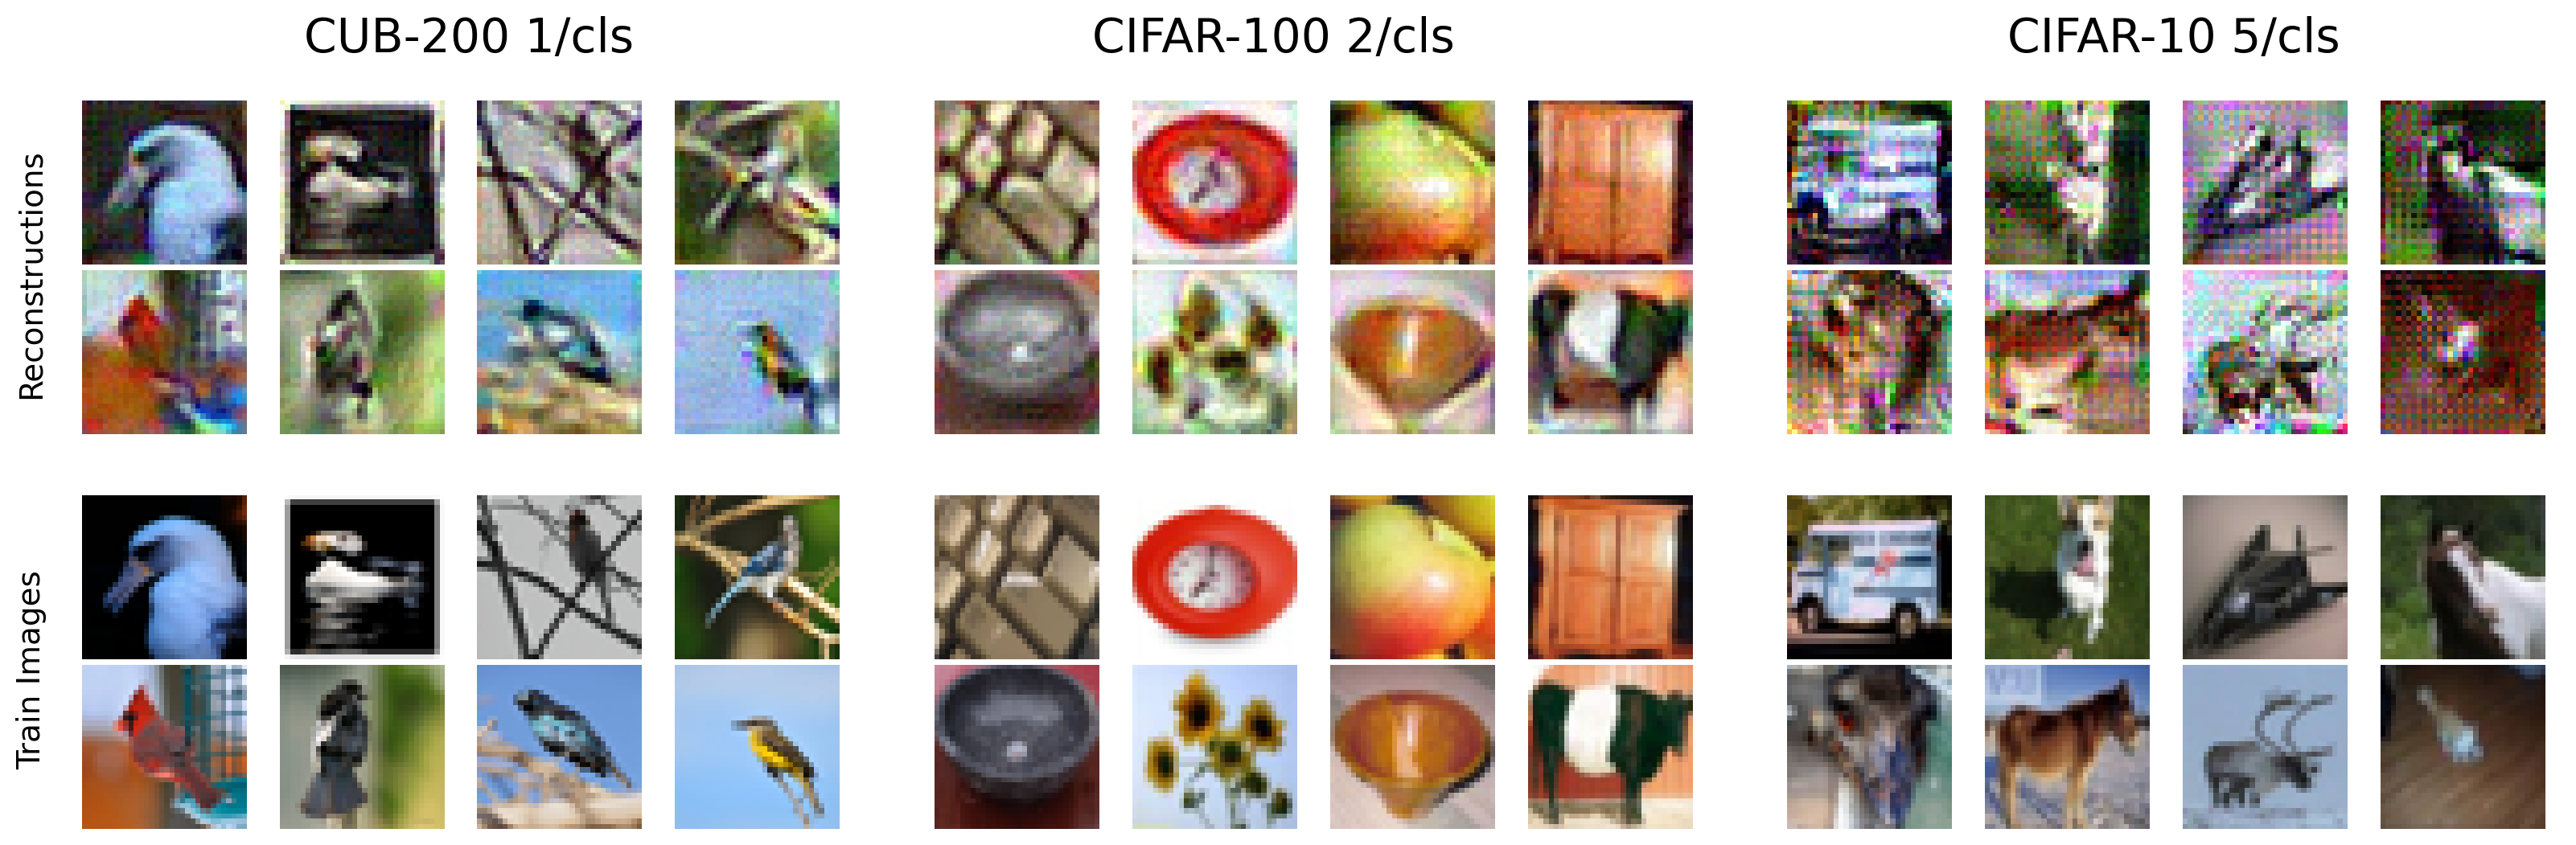

In [56]:
width_ratios = [1 for i in range(14)]
width_ratios[4] = 0.3
width_ratios[9] = 0.3

fig, ax = plt.subplots(5, 14, dpi = 200, figsize = (20, 6), gridspec_kw = {'height_ratios':[1,1, 0.3, 1,1], 'width_ratios': width_ratios})

plt.subplots_adjust(wspace=0.02,hspace=0.04)


##### Loading MNIST reconstructions

recon_images = np.array(pickle.load(open('./fine_tune/cub200_xent/reconstruction_amp_2.pkl', 'rb'))['images'])
training_set_dict = pickle.load(open('./fine_tune/cub200_xent/training_set.pkl', 'rb'))
train_images = np.array(training_set_dict['train_images'])
train_mean = np.array(training_set_dict['train_mean'])

recon_images = correct_mean(recon_images, train_mean)
train_images = correct_mean(train_images, train_mean)

best_pairs = get_best_pairs_ssim(train_images, recon_images)

train_images_best = train_images[best_pairs[:, 0][:8]]
recon_images_ordered = recon_images[best_pairs[:, 1][:8]]



plot_images(recon_images_ordered, fig_ax = (fig, ax))
plot_images(train_images_best, fig_ax = (fig, ax[3:]))


##### Loading CIFAR-10 reconstructions

recon_images = np.array(pickle.load(open('./fine_tune/cifar100_xent/reconstruction_amp_2.pkl', 'rb'))['images'])
training_set_dict = pickle.load(open('./fine_tune/cifar100_xent/training_set.pkl', 'rb'))
train_images = np.array(training_set_dict['train_images'])
train_mean = np.array(training_set_dict['train_mean'])

recon_images = correct_mean(recon_images, train_mean)
train_images = correct_mean(train_images, train_mean)

best_pairs = get_best_pairs_ssim(train_images, recon_images)

train_images_best = train_images[best_pairs[:, 0][:8]]
recon_images_ordered = recon_images[best_pairs[:, 1][:8]]


plot_images(recon_images_ordered, fig_ax = (fig, ax[:, 5:]))
plot_images(train_images_best, fig_ax = (fig, ax[3:, 5:]))


##### Loading CIFAR-10 reconstructions

recon_images = np.array(pickle.load(open('./fine_tune/cifar10_xent/reconstruction_amp_2.pkl', 'rb'))['images'])
training_set_dict = pickle.load(open('./fine_tune/cifar10_xent/training_set.pkl', 'rb'))
train_images = np.array(training_set_dict['train_images'])
train_mean = np.array(training_set_dict['train_mean'])

recon_images = correct_mean(recon_images, train_mean)
train_images = correct_mean(train_images, train_mean)

best_pairs = get_best_pairs_ssim(train_images, recon_images)

train_images_best = train_images[best_pairs[:, 0][:8]]
recon_images_ordered = recon_images[best_pairs[:, 1][:8]]


plot_images(recon_images_ordered, fig_ax = (fig, ax[:, 10:]))
plot_images(train_images_best, fig_ax = (fig, ax[3:, 10:]))

for a in range(14):
    ax[2, a].axis('off')
    
for a in range(5):
    ax[a, 4].axis('off')
    ax[a, 9].axis('off')

fig.text(0.25, 0.93, 'CUB-200 1/cls', fontsize = 21, ha = 'center')
fig.text(0.5, 0.93, 'CIFAR-100 2/cls', fontsize = 21, ha = 'center')
fig.text(0.78, 0.93, 'CIFAR-10 5/cls', fontsize = 21, ha = 'center')

fig.text(0.114, 0.70, 'Reconstructions', ha = 'center', fontsize = 14, rotation = 90, va = 'center')

fig.text(0.114, 0.29, 'Train Images', ha = 'center', fontsize = 14, rotation = 90, va = 'center')


plt.savefig('fine_tune.png', bbox_inches='tight')